# Lunar Lander Final Project
## JonPaul Ferzacca
### CSPB 3202 Intro to AI - Professor Truong


### Dependencies

In [ ]:
!pip install swig
!pip install gym[box2d]
!pip install gym --upgrade
!pip install keras-rl
!apt-get install ffmpeg

### Import Necessary Packages

In this section, we import the necessary Python packages for our deep Q-learning model.*italicized text*

In [ ]:
import torch  # Importing PyTorch for neural network functionality
import torch.nn as nn  # Importing neural network module
import torch.optim as optim  # Importing optimization algorithms

import random  # For random number generation
import numpy as np  # For numerical operations
import gym  # Importing OpenAI Gym for reinforcement learning environments
from gym.wrappers import RecordVideo  # Wrapper to record video of the agent's performance
from tqdm import tqdm  # For displaying progress bars
from collections import deque, namedtuple  # deque for efficient FIFO operations, namedtuple for structured data
import matplotlib.pyplot as plt  # For plotting graphs


### Configure Compute Device

Determine if CUDA (GPU support) is available in the environment and set the device accordingly.


In [ ]:
# Determine if CUDA (GPU support) is available and use it; otherwise, use CPU
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Define the Q-Learning Network

Here, we define the neural network that will serve as our Q-learning model. It consists of fully connected layers with ReLU activations.


In [ ]:
class QLearningNetwork(nn.Module):  # Define the class QLearningNetwork inheriting from nn.Module
    def __init__(self, state_size, action_size, hidden_size=64):  # Initialize the network
        super(QLearningNetwork, self).__init__()  # Initialize the superclass
        self.main = nn.Sequential(  # Define a sequential model
            nn.Linear(state_size, hidden_size),  # First linear layer from state_size to hidden_size
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_size, hidden_size),  # Second linear layer (hidden layer)
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_size, action_size)  # Final layer from hidden_size to action_size
        )

    def forward(self, input_tensor):  # Forward pass definition
        return self.main(input_tensor)  # Pass the input through the sequential model


### Deep Q-Learning Agent

This section defines the deep Q-learning agent, which includes functions for selecting actions, storing experiences, and learning from them.

In [ ]:
class ReinforcementAgent():  # Define the ReinforcementAgent class
    def __init__(self, state_space, action_space, batch_size=64, alpha=1e-4, discount_rate=0.99, buffer_size=int(1e5), update_freq=5, tau=1e-3):  # Constructor with parameters
        self.state_space = state_space  # State space size
        self.action_space = action_space  # Action space size
        self.batch_size = batch_size  # Batch size for training
        self.discount_rate = discount_rate  # Discount rate for future rewards
        self.update_freq = update_freq  # Frequency of learning updates
        self.tau = tau  # Soft update parameter

        # Policy and target networks using the QLearningNetwork
        self.policy_net = QLearningNetwork(state_space, action_space).to(compute_device)
        self.target_net = QLearningNetwork(state_space, action_space).to(compute_device)

        self.optim = optim.Adam(self.policy_net.parameters(), lr=alpha)  # Optimizer
        self.loss = nn.MSELoss()  # Loss function (Mean Squared Error Loss)

        # Experience replay buffer
        self.experience_replay = MemoryBuffer(action_space, buffer_size, batch_size)
        self.update_counter = 0  # Counter to keep track of learning updates

    # Method to select an action based on the current state and exploration rate
    def decide_action(self, observation, exploration_rate):
        # Convert the observation to a PyTorch tensor and move it to the compute device (CPU or GPU)
        observation = torch.from_numpy(observation).float().unsqueeze(0).to(compute_device)
        self.policy_net.eval()  # Set policy_net to evaluation mode
        with torch.no_grad():  # Disable gradient calculations
            action_values = self.policy_net(observation)  # Get action values from policy_net
        self.policy_net.train()  # Set policy_net back to training mode

        if random.random() < exploration_rate:  # Explore with probability of exploration_rate
            return random.choice(np.arange(self.action_space))  # Random action
        else:  # Exploit the best known action
            return np.argmax(action_values.cpu().data.numpy())  # Action with the highest value

    # Method to store experiences in the replay buffer
    def store_experience(self, state, action, reward, next_state, is_done):
        self.experience_replay.add(state, action, reward, next_state, is_done)  # Add experience to the buffer
        self.update_counter += 1  # Increment the update counter

        # Perform learning step if the time is right
        if self.update_counter % self.update_freq == 0:
            if len(self.experience_replay) >= self.batch_size:  # Check if buffer has enough samples
                experiences = self.experience_replay.sample()  # Sample a batch of experiences
                self.learn(experiences)  # Learn from the experiences

    # Method for the learning process
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences  # Unpack the experiences
        # Compute Q target values for next states
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute the expected Q values
        Q_targets = rewards + (self.discount_rate * Q_targets_next * (1 - dones))
        Q_expected = self.policy_net(states).gather(1, actions)

        # Compute loss and backpropagate
        loss_val = self.loss(Q_expected, Q_targets)
        self.optim.zero_grad()  # Zero the gradients
        loss_val.backward()  # Backpropagate the loss
        self.optim.step()  # Update network weights
        # Soft update target network parameters
        self.soft_update(self.policy_net, self.target_net)

    # Method for soft updating the target network
    def soft_update(self, local_model, target_model):
        for local_param, target_param in zip(local_model.parameters(), target_model.parameters()):
            # Update target model parameters slightly towards the local model parameters
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


### Experience Replay Buffer

The replay buffer stores experiences that the agent encounters for later training. This helps in breaking the correlation between consecutive experiences.


In [ ]:
class MemoryBuffer():
    def __init__(self, action_dimensions, memory_capacity, batch_size):
        self.action_dimensions = action_dimensions  # Number of action dimensions
        self.memory = deque(maxlen=memory_capacity)  # Create a deque for memory buffer
        self.batch_size = batch_size  # Batch size for sampling from the buffer
        # Namedtuple for structuring experience data
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "is_done"])

    def __len__(self):
        return len(self.memory)  # Return the current size of the internal memory

    def add(self, state, action, reward, next_state, is_done):
        e = self.experience(state, action, reward, next_state, is_done)  # Create an experience tuple
        self.memory.append(e)  # Append the experience to the memory

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)  # Randomly sample a batch of experiences
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(compute_device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(compute_device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(compute_device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(compute_device)
        dones = torch.from_numpy(np.vstack([e.is_done for e in experiences if e is not None]).astype(np.uint8)).float().to(compute_device)
        return (states, actions, rewards, next_states, dones)


### Training the Agent

Define the function to train the agent. This function will run the agent through multiple episodes, updating the network parameters based on the agent's experiences.


In [ ]:
# Function for training the agent
def train_agent(environment, deep_q_agent, total_episodes=2000, max_steps=1000, start_epsilon=1.0, end_epsilon=0.1, epsilon_decay=0.995, desired_score=200, checkpoint=False, record_interval=100):
    score_history = []  # List to keep track of scores for each episode
    epsilon = start_epsilon  # Initial exploration rate

    # Progress bar to visualize the training progress
    progress_bar = tqdm(range(total_episodes), desc="Training Progress", unit="episode")
    for episode in progress_bar:
        # Set up recording environment based on the specified recording interval
        if episode % record_interval == 0:
            recording_env = RecordVideo(environment, video_folder=f'video/episode_{episode}')
        else:
            recording_env = environment  # Use the regular environment if not recording

        state = recording_env.reset()  # Reset the environment to start a new episode
        episode_score = 0  # Initialize the score for the current episode

        # Iterate over steps within the episode
        for step in range(max_steps):
            # Decide on an action based on the current state and exploration rate
            action = deep_q_agent.decide_action(state, epsilon)
            # Perform the action in the environment and observe the outcome
            next_state, reward, done, _ = recording_env.step(action)
            # Store the experience (state transition) in the agent's memory buffer
            deep_q_agent.store_experience(state, action, reward, next_state, done)
            state = next_state  # Update the state to the next state
            episode_score += reward  # Add the reward to the total score of the episode

            if done:  # If the episode has ended, exit the loop
                break

        # Add the episode's score to the history for later analysis
        score_history.append(episode_score)
        # Calculate the average score of the last 100 episodes
        avg_score = np.mean(score_history[-100:])
        # Update the exploration rate (epsilon) based on its decay
        epsilon = max(end_epsilon, epsilon * epsilon_decay)
        # Update the progress bar with the current score and average score
        progress_bar.set_postfix_str(f"Score: {episode_score:.2f}, Avg Score: {avg_score:.2f}")

        # Check if the desired score is achieved and exit if it is
        if len(score_history) >= 100 and avg_score >= desired_score:
            print("\nTarget score achieved!")
            break

        # Save the model checkpoint at specified intervals
        if checkpoint and episode % record_interval == 0:
            torch.save(deep_q_agent.policy_net.state_dict(), f'checkpoint_episode_{episode}.pth')

    return score_history  # Return the score history for further analysis


### Testing the Agent

After training, this function is used to evaluate the performance of the agent in the environment.


In [ ]:
def test_agent(environment, deep_q_agent, num_tests=3):
    for _ in range(num_tests):  # Loop over the number of test runs
        state = environment.reset()  # Reset the environment at the start of each test
        total_reward = 0  # Initialize total reward for the test

        while True:  # Start an infinite loop for each test
            # Decide the best action (epsilon=0 turns off exploration)
            action = deep_q_agent.decide_action(state, epsilon=0)
            # Perform the action in the environment and observe the outcome
            state, reward, done, _ = environment.step(action)
            total_reward += reward  # Accumulate the reward

            if done:  # Check if the episode (test) is finished
                break  # Exit the loop if the episode is done

        # Print the total reward for each test run
        print(f"Test run score: {total_reward}")


### Display Training Scores

Plot the scores achieved by the agent during training to visualize its learning progress.


In [ ]:
def display_scores(scores):
    plt.figure(figsize=(10, 6))  # Create a figure for plotting
    plt.plot(scores)  # Plot the scores
    plt.title("Agent's Scores Over Episodes")  # Title of the plot
    plt.xlabel("Episode")  # Label for the x-axis
    plt.ylabel("Score")  # Label for the y-axis
    plt.grid()  # Display grid lines on the plot
    plt.show()  # Show the plot

### Main Execution Function

Finally, define the main function where the environment is set up, the agent is initialized, trained, and tested.


In [ ]:
def main():
    # Create the LunarLander environment and wrap it for video recording
    env = gym.make('LunarLander-v2')


    # Get the dimensions of the state space and action space from the environment
    state_space_dim = env.observation_space.shape[0]
    action_space_dim = env.action_space.n

    # Initialize the Reinforcement Agent with specified parameters
    agent = ReinforcementAgent(
        state_space=state_space_dim,
        action_space=action_space_dim,
        batch_size=128,
        alpha=1e-3,
        discount_rate=0.99,
        buffer_size=10000,  # Use buffer_size instead of memory_capacity
        update_freq=5,
        tau=1e-3
    )

    # Train the agent and store the training scores
    training_scores = train_agent(env, agent, total_episodes=5000, desired_score=250, checkpoint=True)
    # Display the training scores on a plot
    display_scores(training_scores)

    # Test the trained agent
    test_agent(env, agent, num_tests=10)

    # Empty CUDA cache if using a GPU
    if str(compute_device) == "cuda":
        torch.cuda.empty_cache()

# Execute the main function when the script is run
if __name__ == "__main__":
    main()

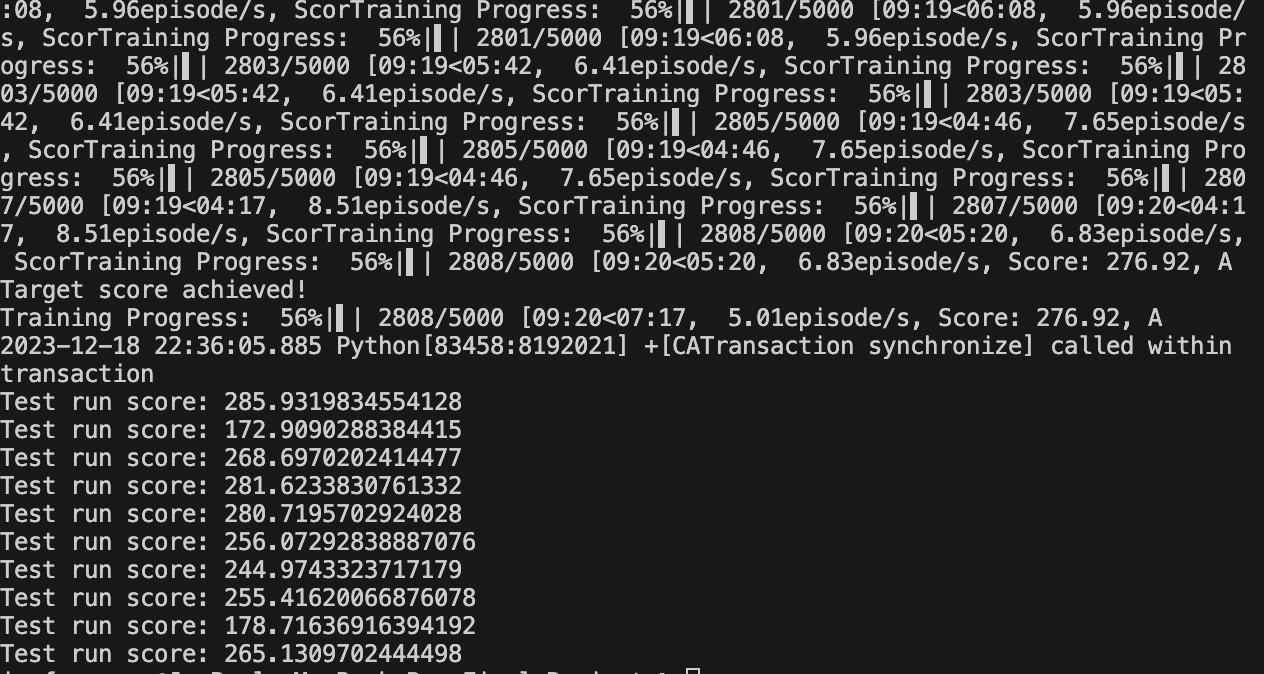



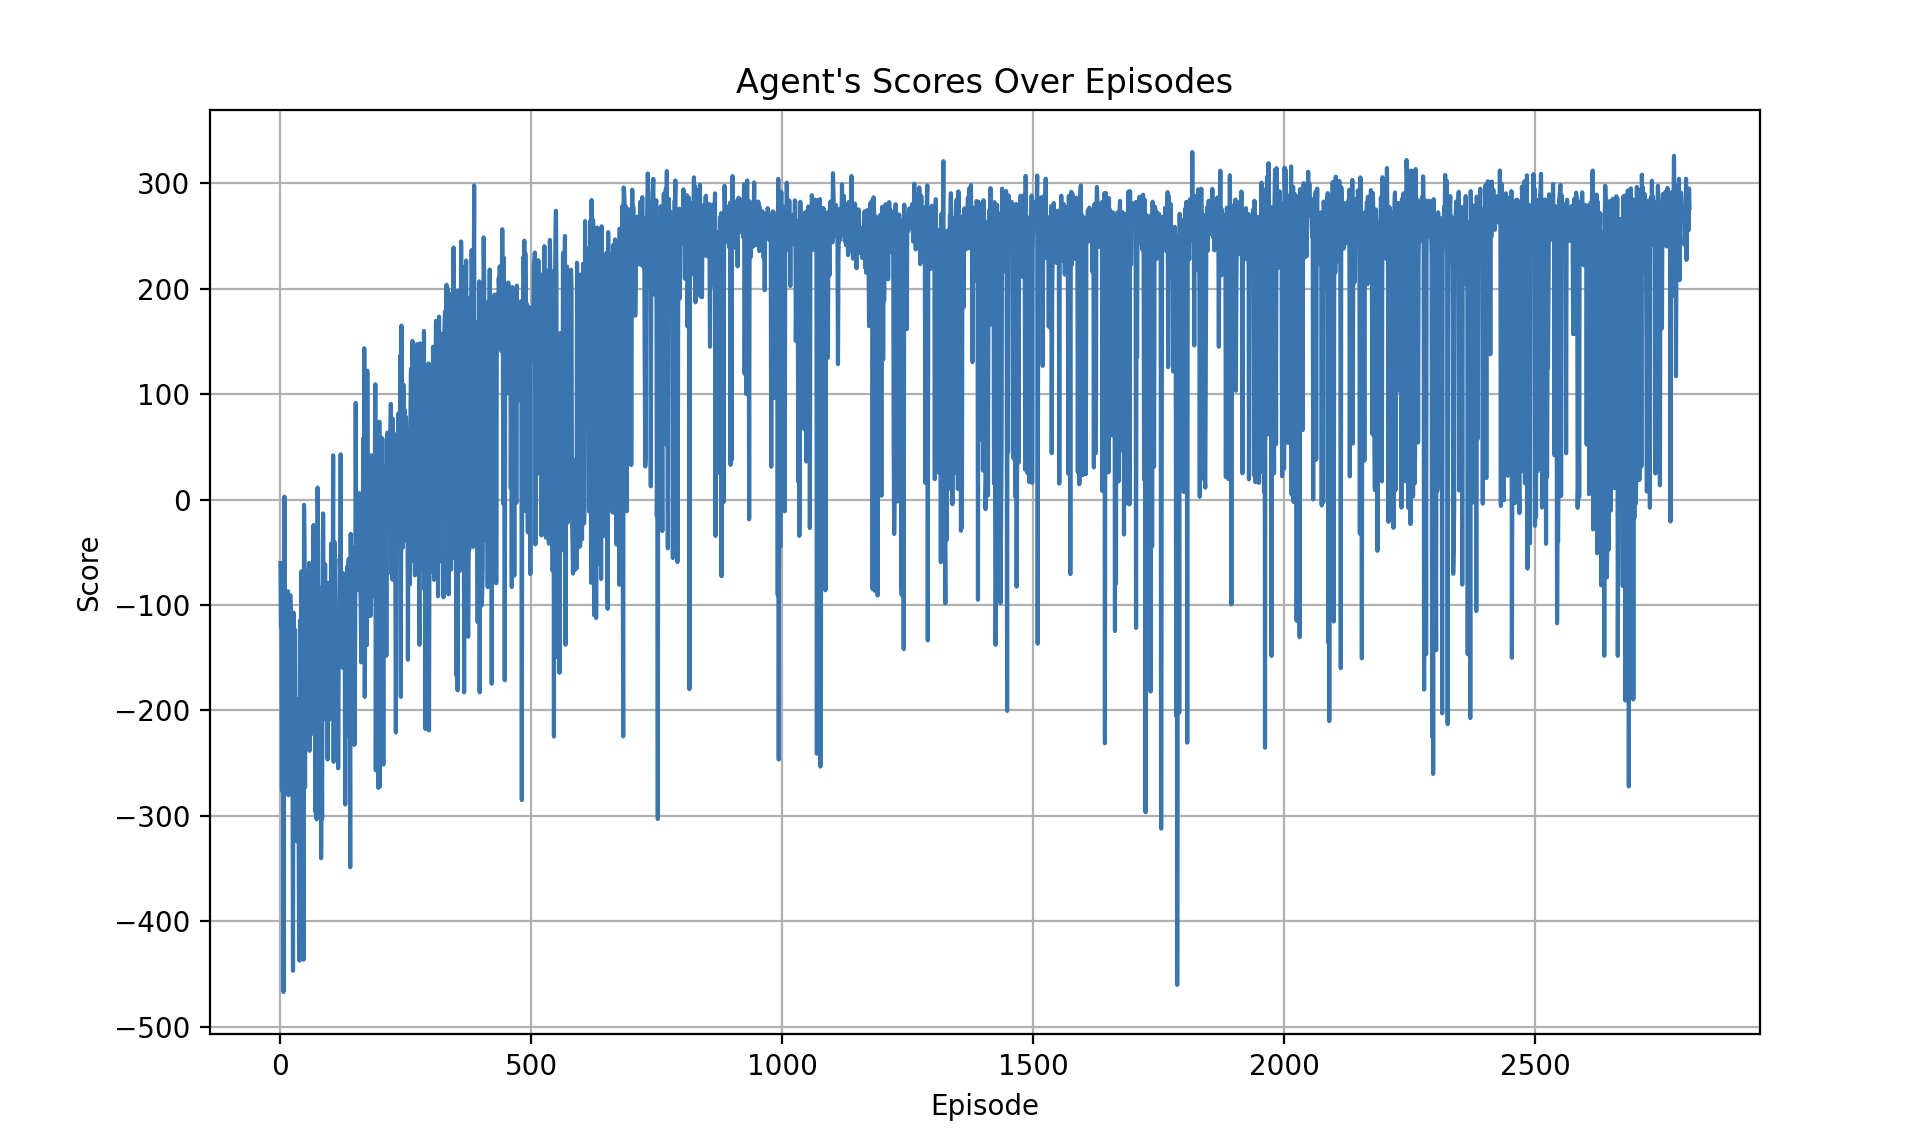
